In [596]:
import pandas as pd
# import oec
#import requests
import numpy as np
import zipfile
import os
import seaborn as sns
from scipy.stats import ks_2samp
%matplotlib inline

In [505]:
### Use the following code to unzip and rename new zipfiles.
# full_demos_minus_cntlist = demo_df.loc[(~demo_df['Country'].isin(country_list)) & (demo_df['Regimetype']=='Full democracy'), 'Country'].values
def unzip_trade_data(cntlist, file_path, country_list=[]):
    """ 
    cntlist: list of new countries for which there are zipfiles to open. 
    file_path: either path_imp_data or path_exp_data
    country_list: list of current countries for which extended trade already exists, i.e. has been unzipped
    """
    for cnt in cntlist:
        with zipfile.ZipFile(file_path.format(cnt) + 'zip',"r") as zip_ref:
            zip_ref.extractall('\\'.join(path_exp_data.split('\\')[:-1]))
            os.rename(file_path.split('-')[0] + '-2018---Click-to-Select' + '.csv', file_path.format(cnt) + 'csv')
        if  cnt not in country_list:  
            country_list.append(cnt)
    return country_list

### The following is a little hobby project, which I have been having fun with during my son's naptime and in the evenings while I was/am on paternity leave. I started it for me to become better acquainted with Neo4j and the Cypher query language syntax, but have chosen to do a sort of back-and-forth with Python to on the one hand demonstrate how easy this is and because some of the data wrangling is faster (at least for me) to do in Python. 
### The idea for the case we will be looking at actually comes from a thought I had a while back about how a company may have a given credit risk assigned by a bank or an ESG score. But what about the companies that the company trades with? What is their credit or ESG scores? And for the credit part, how interconnected are, e.g., the suppliers, are they all vulnerable toward geo-political unrest in a specific part of the world or a drop in the need for oil? 
### If we could map out these relations (e.g. in a graph), we could build what we might call second order credit/ESG scores or which ever order we would like... Unfortunately, such data is not easy to come by, so instead I have dived into the treasure trove of data that is available at [oec](https://legacy.oec.world/en/) from where I have sourced import/export data from a host of countries. I will combine this with democracy scores, which I have found on [wiki](https://en.wikipedia.org/wiki/Democracy_Index) to construct second order democracy scores for each country. Based on the score we will look at if there is a difference in trading behavior between different regime types. While we are here and have the data loaded into Neo4j we will also use some of the functions to determine centrality and communities.
### We start out by retrieving some information about the democracy score for a range of countries. I actually spent quite a while trying to do this with Beautiful Soup, but eventually gave up and opted for pandas' builtin read_html function. (If anyone out there has a nice code snippet to do this with Beautilful Soup for wiki tables that also contain < li > elements then let me know, as I have other ideas for similar projects where this will be needed!)  

In [379]:
democracy_rank = r'https://en.wikipedia.org/wiki/Democracy_Index'
demo_df = pd.read_html(democracy_rank, header=0)[2][:-1] # 

### Let's print out the first ten rows:

In [143]:
demo_df.head(10)

,Rank,Country,Score,Electoral processand pluralism,Functio­ning ofgovern­ment,Politicalpartici­pation,Politicalculture,Civilliberties,Regimetype,Region[n 1],Changes fromlast year
0,1,Norway,9.87,10.00,9.64,10.00,10.00,9.71,Full democracy,Western Europe,Score: Rank:
1,2,Iceland,9.58,10.00,9.29,8.89,10.00,9.71,Full democracy,Western Europe,NaN
2,3,Sweden,9.39,9.58,9.64,8.33,10.00,9.41,Full democracy,Western Europe,NaN
3,4,New Zealand,9.26,10.00,9.29,8.89,8.13,10.00,Full democracy,Asia & Australasia,NaN
4,5,Finland,9.25,10.00,8.93,8.89,8.75,9.71,Full democracy,Western Europe,Score: 0.11Rank: 3
5,6,Ireland,9.24,10.00,7.86,8.33,10.00,10.00,Full democracy,Western Europe,Score: 0.09Rank:
6,7,Denmark,9.22,10.00,9.29,8.33,9.38,9.12,Full democracy,Western Europe,Score: Rank: 2
7,Canada,9.22,9.58,9.64,7.78,9.38,9.71,Full democracy,North America,Score: 0.07Rank: 1,NaN
8,9,Australia,9.09,10.00,8.93,7.78,8.75,10.00,Full democracy,Asia & Australasia,Score: Rank:
9,10,Switzerland,9.03,9.58,9.29,7.78,9.38,9.12,Full democracy,Western Europe,NaN


### We observe that for Canada (and other countries) something is wrong. Studying the html one realizes that this is due to a row value (Rank=7) spanning two rows. It stems from the fact that Denmark and Canada are tied for seventh place. 
### Let's see how many others are affected by this

In [380]:
demo_df.loc[~demo_df.Rank.apply(lambda x: x.isdigit()), demo_df.columns.values[:-1]]

,Rank,Country,Score,Electoral processand pluralism,Functio­ning ofgovern­ment,Politicalpartici­pation,Politicalculture,Civilliberties,Regimetype,Region[n 1]
7,Canada,9.22,9.58,9.64,7.78,9.38,9.71,Full democracy,North America,Score: 0.07Rank: 1
16,Spain,8.29,9.58,7.14,7.78,8.13,8.82,Full democracy,Western Europe,Score: 0.11Rank: 3
36,Lithuania,7.50,9.58,6.43,6.11,6.25,9.12,Flawed democracy,Eastern Europe,NaN
43,Trinidad and Tobago,7.16,9.58,7.14,6.11,5.63,7.35,Flawed democracy,Latin America,Score: Rank:
55,Hungary,6.63,8.75,6.07,5.00,6.25,7.06,Flawed democracy,Eastern Europe,NaN
60,Lesotho,6.54,9.17,4.50,6.67,5.63,6.76,Flawed democracy,Sub-Saharan Africa,Score: 0.1Rank: 4
71,Guyana,6.15,6.92,5.36,6.11,5.00,7.35,Flawed democracy,Latin America,Score: 0.52Rank: 17
75,Singapore,6.02,3.92,7.86,5.00,6.25,7.06,Flawed democracy,Asia & Australasia,Score: 0.36Rank: 9
89,Honduras,5.42,7.83,4.29,4.44,4.38,6.18,Hybrid regime,Latin America,Score: 0.21Rank: 4
97,Zambia,5.09,4.75,2.93,4.44,6.88,6.47,Hybrid regime,Sub-Saharan Africa,Score: 0.52Rank: 11


### Next we will fix this. (We actully won't be using the rank directly, but still...) 

In [381]:
tmp_df = demo_df.loc[~demo_df.Rank.apply(lambda x: x.isdigit()), demo_df.columns.values[:-1]]
demo_df.loc[~demo_df.Rank.apply(lambda x: x.isdigit()), 'Rank'] = '-'
demo_df.loc[~demo_df.Rank.apply(lambda x: x.isdigit()), demo_df.columns.values[1:]] = tmp_df.values
demo_df.head(10)

,Rank,Country,Score,Electoral processand pluralism,Functio­ning ofgovern­ment,Politicalpartici­pation,Politicalculture,Civilliberties,Regimetype,Region[n 1],Changes fromlast year
0,1,Norway,9.87,10.00,9.64,10.00,10.00,9.71,Full democracy,Western Europe,Score: Rank:
1,2,Iceland,9.58,10.00,9.29,8.89,10.00,9.71,Full democracy,Western Europe,NaN
2,3,Sweden,9.39,9.58,9.64,8.33,10.00,9.41,Full democracy,Western Europe,NaN
3,4,New Zealand,9.26,10.00,9.29,8.89,8.13,10.00,Full democracy,Asia & Australasia,NaN
4,5,Finland,9.25,10.00,8.93,8.89,8.75,9.71,Full democracy,Western Europe,Score: 0.11Rank: 3
5,6,Ireland,9.24,10.00,7.86,8.33,10.00,10.00,Full democracy,Western Europe,Score: 0.09Rank:
6,7,Denmark,9.22,10.00,9.29,8.33,9.38,9.12,Full democracy,Western Europe,Score: Rank: 2
7,-,Canada,9.22,9.58,9.64,7.78,9.38,9.71,Full democracy,North America,Score: 0.07Rank: 1
8,9,Australia,9.09,10.00,8.93,7.78,8.75,10.00,Full democracy,Asia & Australasia,Score: Rank:
9,10,Switzerland,9.03,9.58,9.29,7.78,9.38,9.12,Full democracy,Western Europe,NaN


### And we see that Canada (and the rest, though not shown) have been fixed. 
### Now we do away with the last column which we will not use, and make some minor fixes that are required to make the data on democracy scores be aligned with the trade data we will be loading in the following

In [382]:
demo_df.drop(demo_df.columns.values[-1], axis=1, inplace=True)
demo_df.loc[demo_df['Country']=='Eswatini', 'Country'] = 'Swaziland'
demo_df.loc[demo_df['Country']=='Taiwan', 'Country'] = 'Chinese Taipei'
demo_df.loc[demo_df['Country']=='Myanmar', 'Country'] = 'Burma'
demo_df.loc[demo_df['Country']=='South Korea[n 2]', 'Country'] = 'South Korea'
demo_df.loc[demo_df['Country'].str.contains('Ivory'), 'Country'] = 'Cote d\'Ivoire'
demo_df.loc[demo_df['Country'].str.contains('Cze'), 'Country'] = 'Czechia'
# demo_df.columns

In [406]:
demo_df['Score'] = demo_df['Score'].astype(float)

### Let's do a quick groupby on region and look at the stats for the democracy score:

In [407]:
demo_df.groupby('Region[n 1]')['Score'].describe()

,count,mean,std,min,25%,50%,75%,max
Region[n 1],,,,,,,,
Asia & Australasia,28.0,5.666071,2.111686,1.08,4.0750,6.025,6.9650,9.26
Eastern Europe,28.0,5.421786,1.948682,1.72,4.4225,5.895,6.7300,7.90
Latin America,24.0,6.133750,1.508722,2.84,5.3800,6.435,7.0275,8.38
Middle East & North Africa,20.0,3.528500,1.600517,1.43,2.5075,3.125,3.9500,7.86
North America,2.0,8.590000,0.890955,7.96,8.2750,8.590,8.9050,9.22
Sub-Saharan Africa,44.0,4.260227,1.764719,1.13,3.1400,3.980,5.2475,8.22
Western Europe,21.0,8.359524,1.216480,4.09,7.9500,8.520,9.2200,9.87


### We can see that North America (which consists of Canada and the US) has the highest average democracy score, while the Middle East & North Africa has the lowest. 

### In the next part, we load data on import/exports between a list of countries and all other countries. The list comprises all the countries that are deemed full democracies, except for Luxembourg, and then a few other countries that have been picked somewhat randomly plus all the authoritarian regimes.
### The data can be found at [oec](https://legacy.oec.world/en/), and there is an api. I just couldn't make it work based on the python libraries I could find, and seeing as I wanted to work with the interface between Python and Neo4j and not spend my time updating code from a github repo, I opted for the old fashioned, very time consuming, way of downloading csv files. Not very 2020, I know... 

In [514]:
path_cnt_data = r'C:\Users\GU216ZX\.Neo4jDesktop\eci_hs6_hs96_98-18.csv'
path_imp_data = r'C:\Users\GU216ZX\.Neo4jDesktop\Origins-2018 - {}.'
path_exp_data = r'C:\Users\GU216ZX\.Neo4jDesktop\Destinations-2018 - {}.'

In [513]:
country_list = ['Denmark',
                'Sweden',
                'Germany',
                'Norway',
                'North Korea',
                'China',
                'Russia',
                'South Korea',
                'Mexico',
                'United States',
                'India',
                'Nigeria',
                'Brazil',
                'Japan',
                'Iceland',
                'New Zealand',
                'Finland',
                'Ireland',
                'Canada',
                'Australia',
                'Switzerland',
                'Netherlands',
                'United Kingdom',
                'Uruguay',
                'Austria',
                'Spain',
                'Mauritius',
                'Costa Rica',
                'France',
                'Chile',
                'Portugal', 'Chad', 'Democratic Republic of the Congo', 
         'Central African Republic', 'Syria', 
         'Turkmenistan', 'Equatorial Guinea', 
         'Tajikistan', 'Saudi Arabia', 
         'Yemen', 'Uzbekistan', 
         'Libya', 'Laos', 
         'Burundi', 'Iran', 
         'Belarus', 'Bahrain', 
         'Guinea-Bissau', 'Sudan', 
        'United Arab Emirates', 'Djibouti',
        'Cuba', 'Cameroon', 'Afghanistan', 
         'Kazakhstan', 'Oman', 'Egypt', 'Vietnam', 
         'Republic of the Congo', 'Guinea', 
         'Comoros', 'Zimbabwe', 
         'Rwanda', 'Qatar', 
         'Niger', 'Togo', 'Ethiopia', 'Cambodia', 
         'Nicaragua', 'Burma', 'Gabon', 'Mozambique', 'Angola', 'Iraq', 'Palestine', 'Mauritania', 'Kuwait', 'Jordan']

In [512]:
unzip_trade_data(clist, path_exp_data)

['Chad',
 'Democratic Republic of the Congo',
 'Central African Republic',
 'Syria',
 'Turkmenistan',
 'Equatorial Guinea',
 'Tajikistan',
 'Saudi Arabia',
 'Yemen',
 'Uzbekistan',
 'Libya',
 'Laos',
 'Burundi',
 'Iran',
 'Belarus',
 'Bahrain',
 'Guinea-Bissau',
 'Sudan',
 'United Arab Emirates',
 'Djibouti',
 'Cuba',
 'Cameroon',
 'Afghanistan',
 'Kazakhstan',
 'Oman',
 'Egypt',
 'Vietnam',
 'Republic of the Congo',
 'Guinea',
 'Comoros',
 'Zimbabwe',
 'Rwanda',
 'Qatar',
 'Niger',
 'Togo',
 'Ethiopia',
 'Cambodia',
 'Nicaragua',
 'Burma',
 'Gabon',
 'Mozambique',
 'Angola',
 'Iraq',
 'Palestine',
 'Mauritania',
 'Kuwait',
 'Jordan']

### First we retrieve information on the complexity of doing business in a given country for 2018...

In [515]:
df_cnt = pd.read_csv(path_cnt_data)
df_cnt = df_cnt[['2018', 'Country ID', 'Country']]
df_cnt.fillna(-99999,inplace=True)
df_cnt = df_cnt.sort_values('2018', ascending=False).reset_index(drop=True)
df_cnt.rename(columns={'2018': 'Complexity Index'}, inplace=True)

### ... then we run through that nice long list of countries, load their trade data and merge it into the existing dataframe with the complexity index. We do an outer merge, as some countries for which there is trade data and a democracy score may not have had a complexity value assigned to them. 

In [516]:
for cnt in country_list:
    df_imp = pd.read_csv(path_imp_data.format(cnt) + 'csv')
    df_exp = pd.read_csv(path_exp_data.format(cnt) + 'csv')
    df_imp.rename(columns={'Trade Value': 'Import_Value'}, inplace=True)
    df_exp.rename(columns={'Trade Value': 'Export_Value'}, inplace=True)
    df_cnt = df_cnt.merge(df_imp[['Country', 'Import_Value']], on='Country', how='outer')
    df_cnt = df_cnt.merge(df_exp[['Country', 'Export_Value']], on='Country', how='outer')
    df_cnt['Export_Value'].fillna(0, inplace=True)
    df_cnt['Import_Value'].fillna(0, inplace=True)
    df_cnt['Export_Balance_' + cnt] = df_cnt['Export_Value'] - df_cnt['Import_Value']
    df_cnt.rename(columns={'Export_Value': 'Export_Value_' + cnt}, inplace=True)
    df_cnt.rename(columns={'Import_Value': 'Import_Value_' + cnt}, inplace=True)
df_cnt['Complexity Index'].fillna(-99999, inplace=True)

In [517]:
df_cnt.head()

,Complexity Index,Country ID,Country,Import_Value_Denmark,Export_Value_Denmark,Export_Balance_Denmark,Import_Value_Sweden,Export_Value_Sweden,Export_Balance_Sweden,Import_Value_Germany,...,Export_Balance_Palestine,Import_Value_Mauritania,Export_Value_Mauritania,Export_Balance_Mauritania,Import_Value_Kuwait,Export_Value_Kuwait,Export_Balance_Kuwait,Import_Value_Jordan,Export_Value_Jordan,Export_Balance_Jordan
0,2.173286,asjpn,Japan,4.869291e+08,2.060595e+09,1.573666e+09,1.575573e+09,2.633925e+09,1.058352e+09,2.128920e+10,...,-1.775036e+07,16523427.0,1.385429e+08,1.220194e+08,1.883994e+09,6.106479e+09,4.222485e+09,2.567439e+08,6.960573e+07,-1.871381e+08
1,2.011652,euche,Switzerland,9.602878e+08,8.473726e+08,-1.129151e+08,1.447500e+09,1.791278e+09,3.437784e+08,4.787851e+10,...,-4.004209e+07,6032584.0,3.194356e+08,3.134030e+08,5.599990e+08,6.021540e+07,-4.997836e+08,3.486888e+08,1.071506e+07,-3.379737e+08
2,1.943747,asxxb,Chinese Taipei,4.284129e+08,3.456997e+08,-8.271324e+07,6.816879e+08,6.087455e+08,-7.294242e+07,9.165389e+09,...,-7.988392e+06,1526972.0,1.139592e+06,-3.873799e+05,1.759993e+08,4.602864e+09,4.426864e+09,3.092173e+08,8.190885e+07,-2.273084e+08
3,1.895182,eudeu,Germany,2.255111e+10,1.548247e+10,-7.068641e+09,2.999785e+10,1.740686e+10,-1.259099e+10,0.000000e+00,...,-1.345763e+08,83346097.0,9.426607e+07,1.091997e+07,1.582808e+09,4.328440e+07,-1.539524e+09,9.937327e+08,3.321906e+07,-9.605136e+08
4,1.851151,askor,South Korea,1.146605e+09,8.410242e+08,-3.055809e+08,1.086429e+09,1.730338e+09,6.439085e+08,1.069231e+10,...,-9.537601e+07,12619757.0,3.645644e+07,2.383668e+07,1.303062e+09,1.135618e+10,1.005312e+10,5.642130e+08,5.519178e+07,-5.090212e+08


### In the following cell we add the information on regime type, democracy score and region to the dataframe containing the information on trade. 

In [518]:
df_cnt = df_cnt.merge(demo_df[['Country', 'Score', 'Regimetype', 'Region[n 1]']], on='Country', how='left')

In [519]:
df_cnt.loc[df_cnt['Country'].isin(country_list)].head(10)

,Complexity Index,Country ID,Country,Import_Value_Denmark,Export_Value_Denmark,Export_Balance_Denmark,Import_Value_Sweden,Export_Value_Sweden,Export_Balance_Sweden,Import_Value_Germany,...,Export_Balance_Mauritania,Import_Value_Kuwait,Export_Value_Kuwait,Export_Balance_Kuwait,Import_Value_Jordan,Export_Value_Jordan,Export_Balance_Jordan,Score,Regimetype,Region[n 1]
0,2.173286,asjpn,Japan,4.869291e+08,2.060595e+09,1.573666e+09,1.575573e+09,2.633925e+09,1.058352e+09,2.128920e+10,...,1.220194e+08,1.883994e+09,6.106479e+09,4.222485e+09,2.567439e+08,6.960573e+07,-1.871381e+08,7.99,Flawed democracy,Asia & Australasia
1,2.011652,euche,Switzerland,9.602878e+08,8.473726e+08,-1.129151e+08,1.447500e+09,1.791278e+09,3.437784e+08,4.787851e+10,...,3.134030e+08,5.599990e+08,6.021540e+07,-4.997836e+08,3.486888e+08,1.071506e+07,-3.379737e+08,9.03,Full democracy,Western Europe
3,1.895182,eudeu,Germany,2.255111e+10,1.548247e+10,-7.068641e+09,2.999785e+10,1.740686e+10,-1.259099e+10,0.000000e+00,...,1.091997e+07,1.582808e+09,4.328440e+07,-1.539524e+09,9.937327e+08,3.321906e+07,-9.605136e+08,8.68,Full democracy,Western Europe
4,1.851151,askor,South Korea,1.146605e+09,8.410242e+08,-3.055809e+08,1.086429e+09,1.730338e+09,6.439085e+08,1.069231e+10,...,2.383668e+07,1.303062e+09,1.135618e+10,1.005312e+10,5.642130e+08,5.519178e+07,-5.090212e+08,8.00,Flawed democracy,Asia & Australasia
6,1.657048,euswe,Sweden,1.118816e+10,1.119601e+10,7.850594e+06,0.000000e+00,0.000000e+00,0.000000e+00,1.740686e+10,...,-4.527884e+06,8.331883e+07,2.877362e+07,-5.454521e+07,8.133969e+07,6.696142e+06,-7.464355e+07,9.39,Full democracy,Western Europe
8,1.572061,nausa,United States,2.459628e+09,8.571489e+09,6.111861e+09,4.436338e+09,1.105553e+10,6.619191e+09,5.580150e+10,...,-6.510324e+07,3.086499e+09,1.743891e+09,-1.342608e+09,1.461987e+09,1.595866e+09,1.338791e+08,7.96,Flawed democracy,North America
9,1.555594,eufin,Finland,1.386238e+09,2.017950e+09,6.317116e+08,7.463782e+09,9.413590e+09,1.949809e+09,1.108598e+10,...,-1.779087e+06,3.022655e+07,3.906411e+05,-2.983591e+07,7.470932e+07,1.105993e+06,-7.360332e+07,9.25,Full democracy,Western Europe
10,1.544751,euaut,Austria,9.152987e+08,8.486977e+08,-6.660103e+07,2.000287e+09,1.627321e+09,-3.729658e+08,5.093982e+10,...,-2.827545e+07,1.666948e+08,2.834568e+06,-1.638602e+08,6.509115e+07,5.580203e+06,-5.951095e+07,8.29,Full democracy,Western Europe
12,1.486536,eugbr,United Kingdom,3.725013e+09,7.784279e+09,4.059267e+09,7.631217e+09,9.437213e+09,1.805996e+09,4.548460e+10,...,-9.258254e+06,7.908262e+08,5.727813e+08,-2.180450e+08,3.483937e+08,6.270747e+07,-2.856862e+08,8.52,Full democracy,Western Europe
14,1.417421,eufra,France,3.484170e+09,3.664525e+09,1.803549e+08,6.054226e+09,7.194607e+09,1.140381e+09,7.845933e+10,...,-1.536320e+08,6.919714e+08,4.900609e+08,-2.019105e+08,4.033776e+08,4.360063e+07,-3.597769e+08,8.12,Full democracy,Western Europe


In [520]:
for k in df_cnt.select_dtypes(include=[np.float]).columns.values:
    df_cnt[k] = df_cnt[k].fillna(0) 

In [521]:
df_cnt[['Regimetype', 'Region[n 1]']] = df_cnt[['Regimetype', 'Region[n 1]']].fillna('Unknown')

In [522]:
df_cnt.to_csv(r'C:\Users\GU216ZX\.Neo4jDesktop\demo_and_trade_data.csv', index=False)

In [523]:
df_reg = df_cnt['Region[n 1]'].unique()

### It should also be mentioned that there are some countries that are present in the democracy score data set which cannot be found in the trade data and vice versa.. mostly vice versa. One can have a look at the differences by executing the following two cells

In [524]:
print('Countries that are in democracy data but not in the trade data: \n', demo_df.loc[~demo_df['Country'].isin(df_cnt['Country'].values), 'Country'].values)

Countries that are in democracy data but not in the trade data: 
 ['Luxembourg' 'Botswana' 'Belgium' 'Lesotho' 'Namibia' 'Swaziland']


### The most supprising are - perhaps - Luxembourg and Belgium, but if we scrutinize the list below...

In [427]:
print('Countries that are in trade data but not in the democracy data: \n',sorted(df_cnt.loc[~df_cnt['Country'].isin(demo_df['Country'].values), 'Country'].values))

Countries that are in trade data but not in the democracy data: 
 ['American Samoa', 'Andorra', 'Anguilla', 'Antigua and Barbuda', 'Aruba', 'Bahamas', 'Barbados', 'Belgium-Luxembourg', 'Belize', 'Bermuda', 'Bonaire', 'British Indian Ocean Territory', 'British Virgin Islands', 'Brunei', 'Cayman Islands', 'Christmas Island', 'Cocos (Keeling) Islands', 'Cook Islands', 'Curaçao', 'Dominica', 'Falkland Islands', 'French Polynesia', 'French South Antarctic Territory', 'Gibraltar', 'Greenland', 'Grenada', 'Guam', 'Kiribati', 'Macau', 'Maldives', 'Marshall Islands', 'Micronesia', 'Montserrat', 'Nauru', 'Netherlands Antilles', 'New Caledonia', 'Niue', 'Norfolk Island', 'Northern Mariana Islands', 'Palau', 'Pitcairn Islands', 'Saint Barthélemy', 'Saint Helena', 'Saint Kitts and Nevis', 'Saint Lucia', 'Saint Martin', 'Saint Pierre and Miquelon', 'Saint Vincent and the Grenadines', 'Samoa', 'San Marino', 'Sao Tome and Principe', 'Seychelles', 'Solomon Islands', 'Somalia', 'South Sudan', 'Tokelau',

### ... we see that there is an entry called 'Belgium-Luxembourg'. Unfortunately, it is not clear how to split the trade data between the two to combine it with the democracy scores of each country. 

### Next we will dive into the Neo4j part. Remember to have the (empty) graph you want to work with up and running before performing the next part.

In [525]:
# import the neo4j driver for Python
from py2neo import Node, Relationship, Graph, Path

# NodeSelector, Path
from neo4j import GraphDatabase

# Database Credentials

uri             = "bolt://localhost:7687"
userName        = "neo4j"
password        = "test"

# Connect to the neo4j database server
g = Graph("bolt://localhost:7687", auth=(userName, password)) 
# password=password)
# graphDB_Driver  = GraphDatabase.driver(uri, auth=(userName, password))


In [542]:
create_nodes = []
for i in range(df_cnt.shape[0]):
    node = Node('Country'
                , name=df_cnt['Country'][i]
                , country_id = df_cnt['Country ID'][i]
                , complexity_index = df_cnt['Complexity Index'][i]
                , democracy_score = df_cnt['Score'][i]
                , regime_type = df_cnt['Regimetype'][i]
                )
    create_nodes.append(node)


In [543]:
for i in range(df_cnt.shape[0]):
    g.create(create_nodes[i])

In [544]:
create_regions = []
for i in range(len(df_reg)):
    node = Node('Region'
                , name=df_reg[i])
    create_regions.append(node)

In [545]:
for i in range(len(df_reg)):
    g.create(create_regions[i])

### Let's go ahead and query the graph to have a look at what a node actually looks like

In [428]:
g.run("MATCH (a:Country {name:'Angola'}) RETURN a").data()

[{'a': (_119:Country {complexity_index: -1.1981810246, country_id: 'afago', democracy_score: '3.72', name: 'Angola', regime_type: 'Authoritarian'})}]

### In the above query we match the very simple pattern of finding a country-node, which we assign to 'a', where the property-key 'name' has the value 'Angola' and then we return everything on that node. 
### Next we will add some relationships to the graph - right now it just consists of country and region nodes. We start with the export/import relationships between the countries in our country list and all the other countries that we have trade data for (including other countries in the country list). 
### The logic is to run through each of the countries in the country list, and then build relationships to all other countries. To make the graph somewhat sparse, we will only include relationships where the export/import to/from a given country makes up more than 0.5 % of the country from the country list's total export/import. 

In [541]:
exp_rel = []
imp_rel = []
skip_list = []
trade_cutoff = 0.00
# dk_id = df_cnt[df_cnt['Country']=='Denmark'].index
for c in country_list: # Loop thorugh countries for which we have downloaded all their trade data
    skip_list.append(c) # 
    cnt_id = df_cnt[df_cnt['Country']==c].index.values[0]
    c_exp_val = df_cnt['Export_Value_' + c].sum() # Get total export of country c
    c_imp_val = df_cnt['Import_Value_' + c].sum() # Get total import of country c
    
    for j, i in enumerate(df_cnt['Country']):
        e_val = df_cnt.loc[df_cnt['Country']==i, 'Export_Value_' + c].values[0] # Get how much country c exports to country i
        i_val = df_cnt.loc[df_cnt['Country']==i, 'Import_Value_' + c].values[0] # Get how much country c imports from country i
        if i not in skip_list: 
        # If i is in country_list and we already did that country through the outer loop we don't want to duplicate that relationship
            if e_val>trade_cutoff*c_exp_val:
                exp_rel.append(Relationship(create_nodes[cnt_id]
                                            , 'exports_to'
                                            , create_nodes[j]
                                            , export_value_pct = np.round(100*e_val/c_exp_val, 2)
                                            , export_value = np.round(e_val, 0)
                                           )
                              )
            if i_val>trade_cutoff*c_imp_val:
                imp_rel.append(Relationship(create_nodes[j]
                                            , 'imports_from'
                                            , create_nodes[cnt_id]
                                            , import_value_pct = np.round(100*i_val/c_imp_val, 2)
                                            , import_value = np.round(i_val, 0)
                                           )
                              )

In [546]:
print('There are {} import relations'.format(len(imp_rel)))

There are 8688 import relations


In [547]:
print('There are {} export relations'.format(len(exp_rel)))

There are 8752 export relations


### Just to get an idea of what such relations look like and to visually inspect a few to ensure ourselves that they are correct let's print out five

In [533]:
np.random.choice(imp_rel, 5)

array([(Italy)-[:imports_from {import_value: 77859548.0, import_value_pct: 1.49}]->(Palestine),
       (Singapore)-[:imports_from {import_value: 11755759522.0, import_value_pct: 4.64}]->(Vietnam),
       (Saudi Arabia)-[:imports_from {import_value: 37517713909.0, import_value_pct: 2.33}]->(China),
       (Vietnam)-[:imports_from {import_value: 53765613555.0, import_value_pct: 3.34}]->(China),
       (Turkey)-[:imports_from {import_value: 2111163866.0, import_value_pct: 0.72}]->(Switzerland)],
      dtype=object)

### Having asserted ourselves that the relations have been created correctly, it is time to add them to the graph. This is done in the following two cells

In [548]:
for i in range(len(exp_rel)):
    g.create(exp_rel[i])
    

In [549]:
for i in range(len(imp_rel)):    
    g.create(imp_rel[i])

### Next we create the Regions-relationships

In [550]:
reg_rel = []
for i, r in enumerate(df_reg):
#     print(i, r)
#     Relationship(start_node, type, end_node, **properties)[source]
#     create_regions
    for iv in df_cnt.loc[df_cnt['Region[n 1]']==r,].index.values:
        reg_rel.append(Relationship(create_nodes[iv]
                                                , 'belongs_to'
                                                , create_regions[i]))

### Spit out a random seletion of relationships to assert ourselves that it has run correctly

In [537]:
np.random.choice(reg_rel, 5)

array([(Albania)-[:belongs_to {}]->(Eastern Europe),
       (Colombia)-[:belongs_to {}]->(Latin America),
       (Cameroon)-[:belongs_to {}]->(Sub-Saharan Africa),
       (Niue)-[:belongs_to {}]->(Unknown),
       (Bahamas)-[:belongs_to {}]->(Unknown)], dtype=object)

In [551]:
for i in range(len(reg_rel)):    
    g.create(reg_rel[i])

### If we now head on over to our graph in Neo4j, and execute the following cypher query:
MATCH (c: Country {regime_type: 'Full democracy'})-[:belongs_to]->(r:Region) RETURN c, r
### then we should see something like this

![Full democracies along with their regions and trade relationships](files/full_democracies_and_regions.png)

### We can run the same query directly from here by using g.run(<query_statement>), where g i our graph. As can be seen from the below cell this will return the country nodes that are full democracies along with the regions they belong to

In [539]:
g.run("MATCH (c: Country {regime_type: 'Full democracy'})-[:belongs_to]->(r:Region) RETURN c, r").data()[:3]

[{'c': (_72:Country {complexity_index: -0.092719226, country_id: 'ocaus', democracy_score: 9.09, name: 'Australia', regime_type: 'Full democracy'}),
  'r': (_240:Region {name: 'Asia & Australasia'})},
 {'c': (_48:Country {complexity_index: 0.457854552, country_id: 'ocnzl', democracy_score: 9.26, name: 'New Zealand', regime_type: 'Full democracy'}),
  'r': (_240:Region {name: 'Asia & Australasia'})},
 {'c': (_164:Country {complexity_index: -99999.0, country_id: nan, democracy_score: 9.58, name: 'Iceland', regime_type: 'Full democracy'}),
  'r': (_241:Region {name: 'Western Europe'})}]

### Now let's try something different. One thing we could ask ourselves is: "how democratic are the counterparties of each full democracy?" .. Or "which full democracy has the highest amount (in percentage) of its exports going to authoritarian regimes?" This would say something about which democracy is most dependent on regimes that one might perceive as less stable. (Before any economists or others with an interest in regime types and their lifespan get all riled up, I realize that authoritarian regimes need not be unstable, many factors go into that equation.) We could also look at which one imports the most from such countries meaning that it is in dependent on deliverables from these countries. Related to this one is of course also, if some full democracies are major import partners of some of these regimes in which case you could argue that they help perpetuate the regime or are in a position where they could put pressure on the regime.
### To this end, we can define two second order democracy scores for each country, which will be a weigthed average of their counterparties democracy scores (where these exist). We use the export and import values to weight by, and while we are at it we run this not only for the full democracies but for all countries in the country list.
### The code becomes something like this:
MATCH (c:Country)-[e:exports_to]->(cc:Country) 
MATCH (c)<-[i:imports_from]-(cc)
RETURN c.name, c.democracy_score as DEMO_SCORE, sum(e.export_value*cc.democracy_score)/sum(e.export_value) as EXP_SECOND_ORDER_DSCORE , sum(i.import_value*cc.democracy_score)/sum(i.import_value) as IMP_SECOND_ORDER_DSCORE
### Notice that in the second relationship - the one with the import - we just use c and cc. This is because these were defined in the export-relation. 

In [589]:
res = pd.DataFrame(g.run("""MATCH (c:Country)-[e:exports_to]->(cc:Country) 
MATCH (c)<-[i:imports_from]-(cc)
RETURN c.name AS COUNTRY, c.regime_type AS TYPE, c.democracy_score as DEMO_SCORE, 
sum(e.export_value*cc.democracy_score)/sum(e.export_value) as EXP_SECOND_ORDER_DSCORE , 
sum(i.import_value*cc.democracy_score)/sum(i.import_value) as IMP_SECOND_ORDER_DSCORE""").data())

### We have returned the results to a dataframe to make them easier to work with. 

In [590]:
res.tail()

,COUNTRY,DEMO_SCORE,EXP_SECOND_ORDER_DSCORE,IMP_SECOND_ORDER_DSCORE,TYPE
73,Rwanda,3.16,5.590016,5.079613,Authoritarian
74,Palestine,3.89,7.393098,7.161836,Authoritarian
75,Iceland,9.58,7.596261,7.691561,Full democracy
76,Guinea-Bissau,2.63,4.805756,5.189132,Authoritarian
77,Tajikistan,1.93,3.371950,3.614912,Authoritarian


### Next, we will try the same just for authoritarian counterparties. This implies that we have to change the code slightly to make the cc-node have the property value {regime_type: 'Authoritarian'}. We will also rename the second order score columns to reflect that this is for authoritarian regimes only, drop the democracy score and in the next cell merge the data with the dataframe above. "What is this good for?" you ask. Well, it should tell us something like, of the regimes a democracy trades with, just how bad are they

In [591]:
res_auth = pd.DataFrame(g.run("""MATCH (c:Country)-[e:exports_to]->(cc:Country {regime_type: 'Authoritarian'}), 
(c)<-[i:imports_from]-(cc) 
RETURN c.name AS COUNTRY, c.democracy_score AS DEMO_SCORE, 
sum(e.export_value*cc.democracy_score)/sum(e.export_value) AS EXP_SECOND_ORDER_DSCORE, 
sum(i.import_value*cc.democracy_score)/sum(i.import_value) AS IMP_SECOND_ORDER_DSCORE""").data())
res_auth.rename(columns={'EXP_SECOND_ORDER_DSCORE': 'EXP_SO_DSCORE_AUTH', 'IMP_SECOND_ORDER_DSCORE': 'IMP_SO_DSCORE_AUTH'}, inplace=True)
res_auth.drop('DEMO_SCORE', axis=1, inplace=True)
res = res.merge(res_auth, on='COUNTRY', how='left')
res.sort_values('DEMO_SCORE', ascending=False, inplace=True)
res.reset_index(drop=True, inplace=True)

In [600]:
res.groupby('TYPE')[['EXP_SECOND_ORDER_DSCORE', 'IMP_SECOND_ORDER_DSCORE', 'EXP_SO_DSCORE_AUTH', 'IMP_SO_DSCORE_AUTH']].describe().T

TYPE                           Authoritarian  Flawed democracy  \
EXP_SECOND_ORDER_DSCORE count      50.000000          6.000000   
                        mean        5.254348          6.636419   
                        std         1.149110          0.783612   
                        min         3.036237          5.509455   
                        25%         4.283467          6.358072   
                        50%         5.549358          6.508199   
                        75%         6.159555          7.002291   
                        max         7.393098          7.817644   
IMP_SECOND_ORDER_DSCORE count      50.000000          6.000000   
                        mean        5.070396          6.594006   
                        std         1.033642          0.913499   
                        min         2.379469          5.281259   
                        25%         4.316182          6.105747   
                        50%         5.073025          6.540444   
                        75%         5.953655          7.238152   
                        max         7.161836          7.770320   
EXP_SO_DSCORE_AUTH      count      50.000000          6.000000   
                        mean        3.297004          2.886219   
                        std         0.487311          0.086643   
                        min         2.311508          2.780303   
                        25%         2.864628          2.832356   
                        50%         3.369446          2.865572   
                        75%         3.719279          2.958359   
                        max         3.930000          2.995298   
IMP_SO_DSCORE_AUTH      count      50.000000          6.000000   
                        mean        3.263266          2.864970   
                        std         0.481159          0.145943   
                        min         2.273501          2.673206   
                        25%         2.858761          2.764970   
                        50%         3.140768          2.894239   
                        75%         3.698810          2.922332   
                        max         3.930000          3.074560   

TYPE                           Full democracy  Hybrid regime  
EXP_SECOND_ORDER_DSCORE count       21.000000       1.000000  
                        mean         6.339199       7.256285  
                        std          0.799982            NaN  
                        min          4.888376       7.256285  
                        25%          5.751067       7.256285  
                        50%          6.434266       7.256285  
                        75%          6.814521       7.256285  
                        max          7.596261       7.256285  
IMP_SECOND_ORDER_DSCORE count       21.000000       1.000000  
                        mean         6.430618       6.211742  
                        std          0.813159            NaN  
                        min          4.706299       6.211742  
                        25%          6.072637       6.211742  
                        50%          6.427426       6.211742  
                        75%          7.007457       6.211742  
                        max          7.691561       6.211742  
EXP_SO_DSCORE_AUTH      count       21.000000       1.000000  
                        mean         2.836030       3.151671  
                        std          0.237068            NaN  
                        min          2.518685       3.151671  
                        25%          2.710782       3.151671  
                        50%          2.786081       3.151671  
                        75%          2.855976       3.151671  
                        max          3.384552       3.151671  
IMP_SO_DSCORE_AUTH      count       21.000000       1.000000  
                        mean         2.844842       2.678346  
                        std          0.221138            NaN  
                        min          2.507854       2.678

### We can see from the above that the mean second order scores for democracies is higher than for authoritarian regimes. So let's run a test to see if there is a statistically significant difference between who and how much authoritarian regimes and democracies trade with

In [599]:
exp_p = ks_2samp(res.loc[res['TYPE']=='Full democracy', 'EXP_SECOND_ORDER_DSCORE'], res.loc[res['TYPE']=='Authoritarian', 'EXP_SECOND_ORDER_DSCORE'])[1]
imp_p = ks_2samp(res.loc[res['TYPE']=='Full democracy', 'IMP_SECOND_ORDER_DSCORE'], res.loc[res['TYPE']=='Authoritarian', 'IMP_SECOND_ORDER_DSCORE'])[1]
print('There is a statistical difference in export behavior, as the p-value for the test export distributions is {}'.format(exp_p))
print('There is a statistical difference in import behavior, as the p-value for the test import distributions is {}'.format(imp_p))

There is a statistical difference in export behavior, as the p-value for the test export distributions is 0.007296037793547594
There is a statistical difference in import behavior, as the p-value for the test import distributions is 4.131824302011644e-05


### it should be noted that while there is a difference, it may not be that authoritarian regimes necessarily seek to trade more with other regimes. This may be down to geography - we saw earlier that some parts of the world have more authoritarian regimes - or it may be that some embarcos exist which are upheld by democracies but not so much so by other regimes. 

In [588]:
res.sort_values('IMP_SO_DSCORE_AUTH', ascending=True)

,COUNTRY,DEMO_SCORE,EXP_SECOND_ORDER_DSCORE,IMP_SECOND_ORDER_DSCORE,TYPE_x,EXP_SO_DSCORE_AUTH,IMP_SO_DSCORE_AUTH,TYPE_y
77,North Korea,1.08,3.036237,2.379469,Authoritarian,2.311508,2.273501,Authoritarian
0,Norway,9.87,7.258637,6.833617,Full democracy,2.636710,2.507854,Full democracy
11,Germany,8.68,6.814521,6.598342,Full democracy,2.518685,2.515954,Full democracy
2,Sweden,9.39,7.273282,7.248702,Full democracy,2.526347,2.602930,Full democracy
7,Denmark,9.22,7.584841,7.390060,Full democracy,2.560345,2.603286,Full democracy
75,Central African Republic,1.32,3.315502,3.915267,Authoritarian,2.744149,2.642152,Authoritarian
72,Turkmenistan,1.72,4.233169,4.020835,Authoritarian,2.560923,2.646961,Authoritarian
48,Russia,3.11,6.354669,6.411858,Authoritarian,2.687568,2.659066,Authoritarian
25,Brazil,6.86,6.543205,6.723940,Flawed democracy,2.780303,2.673206,Flawed democracy
27,Nigeria,4.12,7.256285,6.211742,Hybrid regime,3.151671,2.678346,Hybrid regime


### Pick out five random entries:

In [575]:
res.loc[np.random.randint(0, res.shape[0], 5), ]

,COUNTRY,DEMO_SCORE,EXP_SECOND_ORDER_DSCORE,IMP_SECOND_ORDER_DSCORE,EXP_SO_DSCORE_AUTH,IMP_SO_DSCORE_AUTH
72,Turkmenistan,1.72,4.233169,4.020835,2.560923,2.646961
29,Kuwait,3.93,6.453752,6.029582,3.916280,3.926233
19,Chile,8.08,5.949588,6.181136,2.855976,2.862876
71,Equatorial Guinea,1.92,6.170298,4.589256,2.843650,2.831318
17,Costa Rica,8.13,5.039957,6.100103,3.384552,3.193273


### Let's combine the second order and first order scores into a new score by applying a simple average and see if that changes the ordering of which country is most democratic

In [576]:
res['DS_AVG'] = (res['DEMO_SCORE'] + res['EXP_SECOND_ORDER_DSCORE'] + res['IMP_SECOND_ORDER_DSCORE'])/3
res.sort_values('DS_AVG', ascending=False)

,COUNTRY,DEMO_SCORE,EXP_SECOND_ORDER_DSCORE,IMP_SECOND_ORDER_DSCORE,EXP_SO_DSCORE_AUTH,IMP_SO_DSCORE_AUTH,DS_AVG
1,Iceland,9.58,7.596261,7.691561,2.783732,2.803228,8.289274
7,Denmark,9.22,7.584841,7.390060,2.560345,2.603286,8.064967
0,Norway,9.87,7.258637,6.833617,2.636710,2.507854,7.987418
2,Sweden,9.39,7.273282,7.248702,2.526347,2.602930,7.970661
5,Ireland,9.24,6.434266,7.682306,2.708264,3.096086,7.785524
4,Finland,9.25,6.812905,7.145535,2.767604,3.018358,7.736147
3,New Zealand,9.26,6.826784,7.007457,2.749536,2.748589,7.698080
23,United States,7.96,7.155320,7.409556,2.832508,2.929439,7.508292
6,Canada,9.22,6.624498,6.677091,2.839672,3.116964,7.507196
9,Switzerland,9.03,6.605776,6.604645,2.788319,2.708708,7.413474


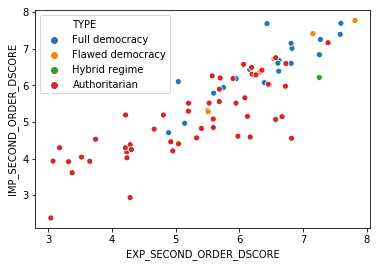

In [593]:
sns.scatterplot(x='EXP_SECOND_ORDER_DSCORE', y='IMP_SECOND_ORDER_DSCORE', hue='TYPE', data=res)